<a href="https://colab.research.google.com/github/RogerUltimate/-Keras-study/blob/main/8_2_code_deep_dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Dream

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2016/01/13<br>
**Last modified:** 2020/05/02<br>
**Description:** Generating Deep Dreams with Keras.

## Introduction

"Deep dream" is an image-filtering technique which consists of taking an image
classification model, and running gradient ascent over an input image to
try to maximize the activations of specific layers (and sometimes, specific units in
specific layers) for this input. It produces hallucination-like visuals.

'딥 드림'은 이미지 분류 모델을 가져다가 입력 이미지에 대해 경사상승을 실행시켜서 특정 층(어떤 때는 특정 층의 특정 unit)의 활성화값을 최대화하는 이미지 필터링 기법. 환각 같은 이미지를 만들어냄. 

It was first introduced by Alexander Mordvintsev from Google in July 2015.

Process:

- Load the original image.
- Define a number of processing scales ("octaves"),
from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.
To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.


## Setup


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

base_image_path = keras.utils.get_file("sky.jpg", "https://i.imgur.com/aGBdQyK.jpg")
result_prefix = "sky_dream"

# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}

# Playing with these hyperparameters will also allow you to achieve new effects
# 아래 하이퍼파라미터들을 바꾸어 보면 새로운 효과를 얻을 수 있음
# 딥드림을 이해하기에 가장 좋은 그림은 <창시자> 책 p.367 그림 8.4
step = 0.01  # Gradient ascent step size: 경사상승 시 학습률로 사용됨
num_octave = 3  # Number of scales at which to run gradient ascent 경사상승을 실행시키는 크기가 몇 개나 있는지
octave_scale = 1.4  # Size ratio between scales: 그림 크기를 1.4배로 계속 키워감
iterations = 20  # Number of ascent steps per scale: 하나의 그림 크기에서 몇 번의 상승 단계를 거치는지
max_loss = 15.0  # loss가 이보다 커지면 경사상승을 멈추어 이미지가 보기 싫어지는 것을 방지


131072/127372 [==============================] - 0s 0us/step


This is our base image: 원본 이미지


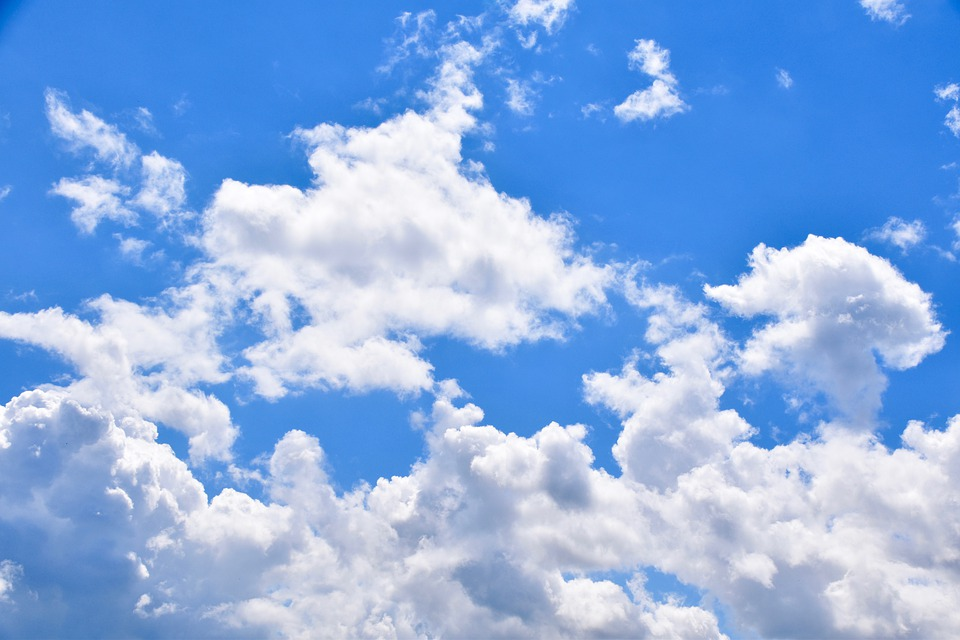

In [2]:
from IPython.display import Image, display

display(Image(base_image_path))


Let's set up some image preprocessing/deprocessing utilities:


In [3]:

def preprocess_image(image_path):          # Neural Style Transfer에서와 동일한 방식
    # Util function to open, resize and format pictures
    # into appropriate arrays.
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # 샘플별로 [0, 255] 범위의 RGB를 입력받아서
    # [-1, 1] 범위의 float32로 바꿔줌. (입출력은 각각 numpy array나 tf.Tensor)
    img = inception_v3.preprocess_input(img)    
    return img


def deprocess_image(x):
    # Util function to convert a NumPy array into a valid image.
    x = x.reshape((x.shape[1], x.shape[2], 3))    
    # Undo inception v3 preprocessing
    x /= 2.0
    x += 0.5
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]  
    x = np.clip(x, 0, 255).astype("uint8")
    return x


## Compute the Deep Dream loss

First, build a feature extraction model to retrieve the activations of our target layers
given an input image.


In [4]:
# Build an InceptionV3 model loaded with pre-trained ImageNet weights
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
# 각각의 '핵심' 층에 대한 상징적(?) 결과물을 구함 (각 층에 고유한 이름을 붙였음)
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]  # 앞서 mixed4~mixed7
    ]
)

# Set up a model that returns the activation values for every target layer
# (as a dict)
# 각 target 층의 활성화 값을 (딕셔너리로) 반환하는 모델을 만듬
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


87916544/87910968 [==============================] - 1s 0us/step


In [5]:
outputs_dict

{'mixed4': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed4')>,
 'mixed5': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>,
 'mixed6': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed6')>,
 'mixed7': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed7')>}

The actual loss computation is very simple:


In [6]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    # Initialize the loss
    loss = tf.zeros(shape=())    # shape을 정의하지 않음
    for name in features.keys():
        coeff = layer_settings[name]    # for name, coeff in features.items(): 처럼 하면 한 줄로 가능함
        activation = features[name]
        
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))   # reduce_prod는 모든 원소를 곱함
                                                                          # 여기서는 shape의 숫자들이 곱해져 전체 원소의 개수를 계산
        # We avoid border artifacts by only involving non-border pixels in the loss.
        # 이미지의 가장자리를 제외함: 상하좌우 가장자리의 2개 줄을 제외함
        # L2 norm (원점으로부터의 거리. 2차원에서는 피타고라스의 정리가 이에 해당)을 계산
        # coeff는 앞서 정의한 각 layer별 가중치                                                                          
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling   
    return loss

## Set up the gradient ascent loop for one octave


In [7]:

@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)       # img는 상수이기 때문에 GradientTape이 watch(계산과정을 기록)하지 않는데, 
                              # 이를 watch하도록 설정함(으로써, img에 대해 gradient를 계산할 수 있게 함)
                              # 참고: https://rfriend.tistory.com/m/556?category=711317
                              # Neural Style Transfer에서는 watch 설정 안 하고도 문제 없었는데 왜 여기서는 하는지??
        loss = compute_loss(img)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients: 중요한 기법이라고 함('important tip')
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6) 
    img += learning_rate * grads     # 경사하강의 반대과정인 듯함. 여기서의 목적은 이미지를 바꾸어 가며 최적의 이미지를 찾는 것
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:     # max_loss가 설정되어 있는데, 그걸 넘어가면 
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img



## Run the training loop, iterating over different octaves


In [8]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]    # H, W

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])  
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]    # 1.4의 세제곱으로 나눈 값, 1.4의 제곱으로 ~, 1.4로 ~ 순서로 됨
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])  # 1.4의 세제곱으로 나눈 값

img = tf.identity(original_img)    # Make a copy
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    # 원본 이미지를 1.4의 'x' 제곱으로 나눈 값으로 축소했다가 크기를 키운 이미지와(upscaled_shrunk_original_img)
    # 원본 이미지를 바로 축소한 이미지(same_size_original)의 차이를 구함
    lost_detail = same_size_original - upscaled_shrunk_original_img

    # lost_detail을 img에 더해줌.....
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy()))


Processing octave 0 with shape (326, 489)
... Loss value at step 0: 0.44
... Loss value at step 1: 0.62
... Loss value at step 2: 0.90
... Loss value at step 3: 1.25
... Loss value at step 4: 1.57
... Loss value at step 5: 1.91
... Loss value at step 6: 2.21
... Loss value at step 7: 2.52
... Loss value at step 8: 2.84
... Loss value at step 9: 3.12
... Loss value at step 10: 3.40
... Loss value at step 11: 3.67
... Loss value at step 12: 3.94
... Loss value at step 13: 4.21
... Loss value at step 14: 4.47
... Loss value at step 15: 4.72
... Loss value at step 16: 4.99
... Loss value at step 17: 5.19
... Loss value at step 18: 5.46
... Loss value at step 19: 5.71
Processing octave 1 with shape (457, 685)
... Loss value at step 0: 1.10
... Loss value at step 1: 1.76
... Loss value at step 2: 2.30
... Loss value at step 3: 2.77
... Loss value at step 4: 3.21
... Loss value at step 5: 3.63
... Loss value at step 6: 4.02
... Loss value at step 7: 4.42
... Loss value at step 8: 4.79
... Los

Display the result.


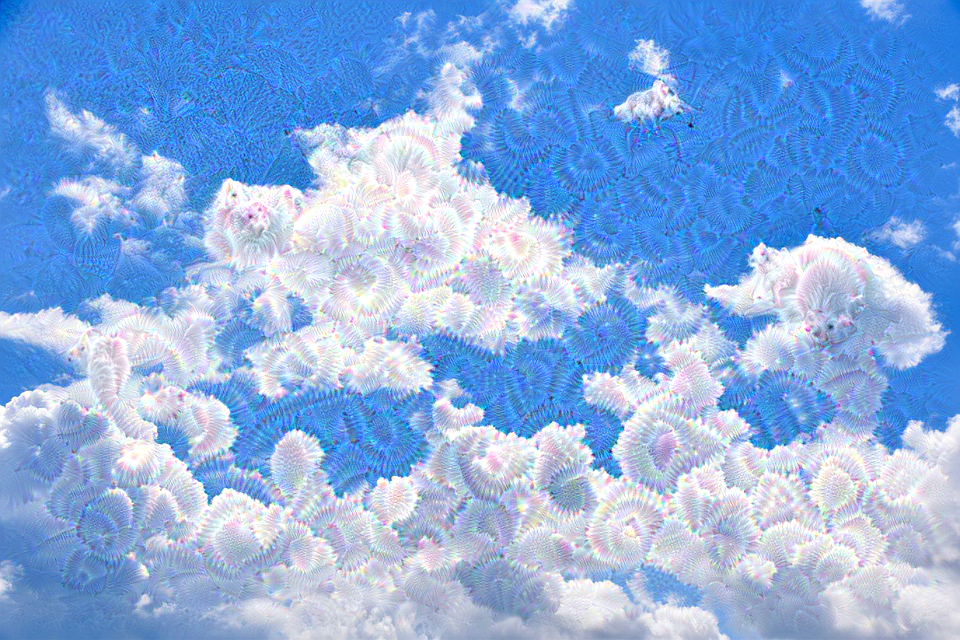

In [9]:
display(Image(result_prefix + ".png"))
